In [1]:
## Langgraph Glossary

## Graphs:
Langgraph  models agent workflows as graphs. We define the behaviour of our agents using three key components:

- State: shared data structure that represents the current snapshot of our app.
- Nodes: functions that encode the logic of our agent. They receive the current state as input and perform some calculation or side effect and return an updated state
- Edges: function to determine which node to execute next time based on the current state. They can be conditional or fix transition.

Nodes do the work and edges tell what to do next

## StateGraph
The main graph class to uses. This is parameterized by a user defined state object

## Message Graph
The class is a special graph which contains a list of messages. Used for chatbots mostly.

## Compiling the graph
To build our graph we first define the state and then add nodes and edges and then we compile the graph.

Compiling provides a few basic checks on the structure of our graph. It is also where we can specify runtime args like checkpointers and breakpoints. We can compile the graph by calling just **compile()** method in the graph after building the edges and node.

graph.compile()

## State
The first thing to do when we define a graph is to define state of the graph.

The state consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state.

The schema of the graph will be the input schema to all Nodes and Edges in the graph.

## Schema
The main documented way to specify the schema of a graph is by using TypedDict or Pydantic model.



In [6]:
from typing import TypedDict

class InputState(TypedDict):
    user_input: str
    
class OverallState(TypedDict):
    foo: str
    user_input: str
    
def node_1(state: InputState) -> OverallState:
    # write in overall state
    return {"foo": state["user_input"] + "name"}

## Building a simple graph

In [10]:
from langgraph.graph import StateGraph, START, END

class GraphState(TypedDict):
    user_input: str
    foo: str
    graph_output: str
    
class InputState(TypedDict):
    user_input: str
    
class OutputState(TypedDict):
    graph_output: str
    
def node_1(state: InputState) -> GraphState:
    return {"foo": state["user_input"] + " <node_1>>"}

def node_2(state: OverallState) -> OutputState:
    return {"graph_output": state["foo"] + " <node_2>>"}

builder = StateGraph(OverallState, input=InputState, output=OutputState)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

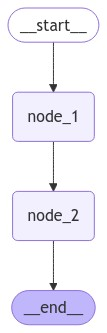

In [11]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"user_input": "Hello"})

## Here first the state user_state: "Hello" + "<node>>1" is stored in the foo state at node1 and then in node2 the foo state is concatenated with "<node_2>>" and stored in the graph_output state. The at the output we get "Hello <node_1>> <node_2>>"

{'graph_output': 'Hello <node_1>> <node_2>>'}

Reducers are key to understanding how updates from nodes are applied to the Graph state. Each key in the state has its own independent reducer function. If no reducer function is explicitly specified then it assumed that all updates to that key should override it. There are a few different types of reducers starting with the default type of reducer.

In [15]:
from typing import TypedDict

class State(TypedDict):
    foo: int
    bar: list[str]
    
# no reducer function specified for any key.

In [17]:
# another example
from typing import TypedDict, Annotated
from operator import add

class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]
    
# annotated type to specity a reducer function operator.add for the second key bar. foo remain unchange but bar will be added to the list.
# input: {"foo": 1, "bar": ["hi"]}
# if second node return "bar": ["bye"]
# state would be {foo: 2(update from node1), bar: ['hi','bye']}


In [18]:
## Context Reducer
# Learn more about this topic more

## Working with messages in graph state

Most modern LLM providers have a chat model interface that accepts a list of messages as input. Langchain's **ChatModel** in particular accepts a list of Message objects as inputs. These messages come in a variety of forms such as HumanMessage or AIMessage.

It is helpful to store prior conversation history as a list of messages in our graph state.
We can add a key(channel) to the graph state that stores a list of Message object and annotate it with a reducer function. The reducer function is vital to telling the graph how to update the list of Message objects in the state with each state update. If we dont specify a reducer state update will overwrite the state an the list of messages will not be a list. Just like above in the bar:['hi','hello'] example.

If we want to manually update messages in our graph state. We need a reducer that can keep track of messages ID and overwrite existing messages instead of appending because Human In The Loop is for that instead of just appending new we update the message. For this function we can use the prebuilt **add_messages** function.

In addition to keeping track of message ID, the add_messages function will also try to deserialize messages into LangChain Message objects whenever a state update is received on the messages channel.

In [19]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Message State
There exist a prebuilt state called MessagesState which makes it easy to use messages. It is defined with a single messages key which is a list of AnyMessage object and uses the add_messages reducer.

In [20]:
from langgraph.graph import MessagesState

class State(MessagesState):
    documents: list[str]

In [23]:
## Node: they are function where the first argument is state and the optional second positional argument is a config containing congifuration for the node.

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph

builder = StateGraph(dict)

def my_node(state: dict, config: RunnableConfig):
    return {"results": f"Hello state['input]"}

builder.add_node("my_node", my_node)

In [22]:
## The START and the END node are special node that represent the node input and output i.e begin and final of the graph in langgraph.

from langgraph.graph import START, END

# Edges define how the logic is routed and how the graph decides to stop.

# 1: Normal Edges: Go directly from one node to the next
# 2: Conditional Edges: Call a function to determing which node to go
# 3: Entry Point: Which node to call first when user input arrives.
# 4: Conditional Entry Point: Call a function to determine which node to call first when user input arrive.

In [ ]:
from langgraph.graph import START, END

def router_function(state):
    return "value"

builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)

builder.add_conditional_edges("my_another_node", router_function)


In [28]:
## LEARN MORE ABOUT
# 1: Send
# 2: Persistence
# 3: Graph Migrations
# 4: Configuration
# 5:Recursion Limit
# 6: Dunamic breakpoint
# 7: Visualization and Streaming